In [5]:
# needed functions and libraries
import pandas as pd
import seaborn as sns

import signature_functions as signature_functions


# Signatures

In [6]:
# preprocess
import warnings
entity_subtypes = 'tissue_topology' # it should be also the same in the signature functions
warnings.filterwarnings('ignore')
report_directory = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.04.21_CJ_batch98_ligand_fix'
annotation_file = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Searches/patient_annotation_solid_cohort_230420.csv'
meta_file_path = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_MTBs_Evaluation/SOLID_TUMORS_Metadata_AS_230323.xlsx'
intensity_file = signature_functions.read_intensity_file(report_directory).transpose()
annotation = pd.read_csv(annotation_file)
ROC_curve_threshold = 0.8
meta_data = pd.read_excel(meta_file_path)
meta_data = meta_data[~meta_data[entity_subtypes].str.contains("\?",na=True)]


In [4]:
# select from the list bellow
meta_data[entity_subtypes].unique().tolist()

['Lung (PUL)',
 'Soft Tissue',
 'n.d.',
 'Bone/Skeleton',
 'Uterus',
 'Digestive tract',
 'Liver (Hep)',
 'Spleen',
 'Lymph Node',
 'Cutaneous/Skin',
 'Adrenal Gland',
 'Soft tissue',
 'Brain',
 'Bone/skeleton',
 'Kidney',
 'n.d. ',
 'Digestive Tract',
 'Soft Tissue ',
 'Thymus']

In [7]:
# t_test criteria
#interested_entity = 'Liver (Hep)'
#interested_entity = 'Lung (PUL)'
interested_entity = 'Soft Tissue'

group1_patients = meta_data['Sample name'][meta_data[entity_subtypes] == interested_entity].tolist()
## To check on a specefic cohort
#interested_cohort = "Sarcoma"
#cohort_patients = meta_data[meta_data['Entity'] == interested_cohort ]
cohort_patients = meta_data
group2_patients = cohort_patients['Sample name'][cohort_patients[entity_subtypes] != interested_entity].to_list()
group_interest = interested_entity
vs_group = 'other_entities'

In [8]:
# one vs all t_test
selected_patients = intensity_file[intensity_file.index.isin([*group1_patients, *group2_patients])]
protein_list = selected_patients.columns
selected_patients['Entity'] = group_interest
selected_patients['Entity'][selected_patients.index.isin(group2_patients)] = vs_group
t_test_df = signature_functions.one_vs_all_t_test(selected_patients, protein_list, group_interest, 'Entity')


final_signatures = signature_functions.get_final_signatures_from_t_test_results_by_criteria(t_test_df, p_value_threshold=0.05,
                                                                                            fdr_threshold=None,
                                                                                            delta_threshold=None)

In [9]:
# adding univariate ROC analysis with permutation based on CV
k_folds = 5
roc_res = [0 for i in range(len(protein_list))]
for i in range(len(protein_list)):
    df = selected_patients.loc[:, [protein_list[i], 'Entity']].dropna()
    if len(df.index) > k_folds:
        if df.groupby('Entity')['Entity'].count().min() > k_folds:
            roc_res[i] = signature_functions.univariate_ROC_analysis_by_CV_permutation(df, group_interest, kFold=k_folds, repeats=1,
                                                                   threshold=ROC_curve_threshold, scores=protein_list[i], labels='Entity')

cv_data = pd.DataFrame(list(zip(protein_list, roc_res)))
cv_data.columns = ['Gene Names', f'ROC_CV_stability_above_{ROC_curve_threshold}']
final_signatures = final_signatures.merge(cv_data, on='Gene Names')

In [10]:
# saving the file
final_signatures.to_excel(f'{report_directory}/{group_interest}_vs_{vs_group}.xlsx')

# Visualization Criteria

In [13]:
new_signatures = signature_functions.get_final_signatures_from_t_test_results_by_criteria(final_signatures, p_value_threshold=None,
                                                                                          fdr_threshold=0.05,
                                                                      delta_threshold=0.25)
final_signatures_list = new_signatures['Gene Names'][(new_signatures[f'ROC_CV_stability_above_{ROC_curve_threshold}'] == 100)].tolist()
sub = selected_patients[final_signatures_list]
protein = sub.columns
sub['patient'] = sub.index
sub = pd.melt(sub, id_vars=['patient'], value_vars=protein, value_name='Intensity')
sub['Entity'] = group_interest
sub['Entity'][sub['patient'].isin(group2_patients)] = vs_group


Swarm Plot

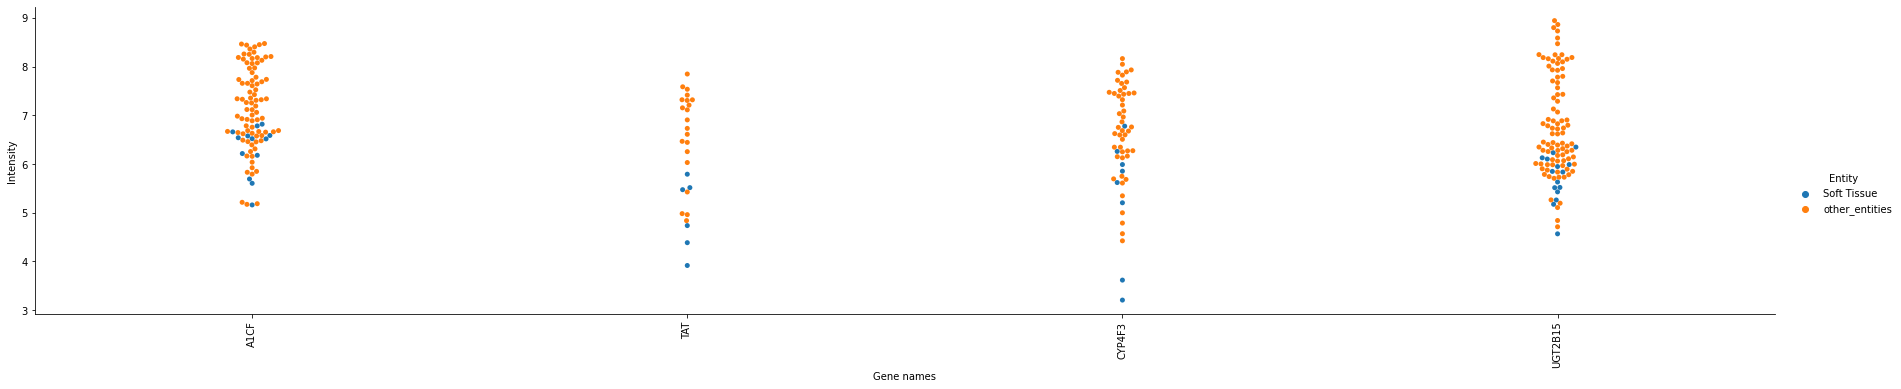

In [14]:
import matplotlib.pyplot as plt
g= sns.catplot(
    data=sub, kind="swarm",
    x="Gene names", y="Intensity", hue="Entity",
    aspect=5
)
rotation = 90 
for i, ax in enumerate(g.fig.axes):   ## getting all axes of the fig object
     ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation)



plt.savefig(f'{report_directory}/{group_interest}_vs_{vs_group}.png', dpi=300)